In [3]:
import numpy as np
from numpy.linalg import eig,svd
import matplotlib.pyplot as plt
import poke.plotting as plot
from astropy.io import fits

In [4]:
# I would like a diattenuation / retuardance converter :)

J = np.array([[1,1j],[0,1e-1]])


In [5]:
evals,evecs = eig(J) # will give us the rotations to quiver
W,D,Vh = svd(J) # gives the diattenuation, retardance


We can convert V adjoint into V through the inverse because it is unitary! This gives us the retarder U

In [6]:
U = W @ np.linalg.inv(Vh)

In [7]:
diattenuation = (np.max(D)**2 - np.min(D)**2)/(np.max(D)**2 + np.min(D)**2)

In [8]:
uval,uvec = eig(U)
retardance = np.abs(np.angle(uval[0])-np.angle(uval[1])) # CLY 5.81

In [29]:
jones.shape

(256, 256, 2, 2)

In [9]:
def ComputeDRFromJones(J):

    from scipy.linalg import polar

    evals,evecs = eig(J) # will give us the rotations to quiver
    W,D,Vh = svd(J) # gives the diattenuation, retardance
    diattenuation = (np.max(D)**2 - np.min(D)**2)/(np.max(D)**2 + np.min(D)**2) # CLY 5.102
    U,P = polar(J)
    # U = W @ np.linalg.inv(Vh)
    uval,uvec = eig(U)
    retardance = np.abs(np.angle(uval[0])-np.angle(uval[1])) # CLY 5.81

    return evecs,diattenuation,retardance


In [30]:
def DRPlot(Jpupil,interpolate=None):

    """
    Jpupil is dimension npix,npix,2,2
    """
    evecs = np.empty([Jpupil.shape[0],Jpupil.shape[1],2,2])
    dia = np.empty([Jpupil.shape[0],Jpupil.shape[1]])
    ret = np.empty([Jpupil.shape[0],Jpupil.shape[1]])

    for i in range(Jpupil.shape[0]):
        for j in range(Jpupil.shape[1]):

            evec,d,r = ComputeDRFromJones(Jpupil[i,j,:,:])

            # First Eigenpolarization
            evecs[i,j,0,0] = evec[0,0]
            evecs[i,j,1,0] = evec[1,0]

            # Second Eigenpolarization
            evecs[i,j,0,1] = evec[0,1]
            evecs[i,j,1,1] = evec[1,1]
            
            dia[i,j] = d 
            ret[i,j] = r

    if interpolate != None:

        from scipy.ndimage import zoom

        Jpupil = zoom(Jpupil,[1/interpolate,1/interpolate,1,1])
        evecs = np.empty([Jpupil.shape[0],Jpupil.shape[1],2,2])

        for i in range(Jpupil.shape[0]):
            for j in range(Jpupil.shape[1]):

                evec,d,r = ComputeDRFromJones(Jpupil[i,j,:,:])

                # First Eigenpolarization
                evecs[i,j,0,0] = evec[0,0]
                evecs[i,j,1,0] = evec[1,0]

                # Second Eigenpolarization
                evecs[i,j,0,1] = evec[0,1]
                evecs[i,j,1,1] = evec[1,1]

    
    return evecs,dia,ret

In [31]:
# load jones pupil
pth = 'Subaru_M1-M3_750nm.fits'
jones_pupil = fits.open(pth)[0].data
jones = jones_pupil[:,:,:2,:2,0] + 1j*jones_pupil[:,:,:2,:2,1]

In [37]:
evecs,dia,ret = DRPlot(jones,interpolate=256/16)

<ipython-input-30-d2e47c127512>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[i,j,0,0] = evec[0,0]
<ipython-input-30-d2e47c127512>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[i,j,1,0] = evec[1,0]
<ipython-input-30-d2e47c127512>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[i,j,0,1] = evec[0,1]
<ipython-input-30-d2e47c127512>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[i,j,1,1] = evec[1,1]
<ipython-input-30-d2e47c127512>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[i,j,0,0] = evec[0,0]
<ipython-input-30-d2e47c127512>:40: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[i,j,1,0] = evec[1,0]
<ipython-input-30-d2e47c127512>:43: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[i,j,0,1] = evec[0,1]
<ipython-input-30-d2

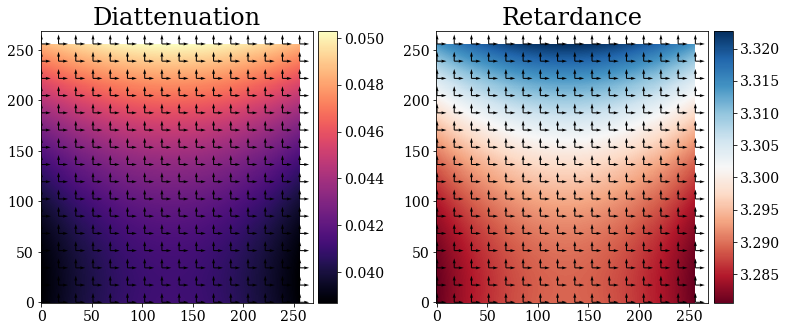

In [42]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

x = np.linspace(0,256,evecs.shape[0])
x,y = np.meshgrid(x,x)

fig,ax = plt.subplots(ncols=2,figsize=[13,5])

im = ax[0].imshow(dia,cmap='magma',zorder=0)
ax[0].quiver(x,y,evecs[:,:,0,0],evecs[:,:,1,0],zorder=1)
ax[0].quiver(x,y,evecs[:,:,0,1],evecs[:,:,1,1],zorder=1)
ax[0].set_title('Diattenuation')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax)

im = ax[1].imshow(ret,cmap='RdBu',zorder=0)
ax[1].quiver(x,y,evecs[:,:,0,0],evecs[:,:,1,0],zorder=1)
ax[1].quiver(x,y,evecs[:,:,0,1],evecs[:,:,1,1],zorder=1)
ax[1].set_title('Retardance')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax)
# plt.quiver()

plt.show()


In [22]:
evecs[:,:,0,0].shape

(256, 256)

In [40]:
evecs

array([[[[ 9.99998596e-01, -1.97113005e-04],
         [-7.48291223e-04,  9.99998297e-01]],

        [[ 9.99998928e-01, -1.71164177e-04],
         [-6.55092508e-04,  9.99998699e-01]],

        [[ 9.99999222e-01, -1.45080289e-04],
         [-5.59119080e-04,  9.99999054e-01]],

        ...,

        [[ 9.99999222e-01,  1.45080257e-04],
         [ 5.59119111e-04,  9.99999054e-01]],

        [[ 9.99998928e-01,  1.71164177e-04],
         [ 6.55092508e-04,  9.99998699e-01]],

        [[ 9.99998596e-01,  1.97113005e-04],
         [ 7.48291223e-04,  9.99998297e-01]]],


       [[[ 9.99999407e-01, -6.89525332e-05],
         [-5.49994049e-04,  9.99999238e-01]],

        [[ 9.99999545e-01, -5.96730225e-05],
         [-4.82656125e-04,  9.99999415e-01]],

        [[ 9.99999668e-01, -5.04350133e-05],
         [-4.12787945e-04,  9.99999573e-01]],

        ...,

        [[ 9.99999668e-01,  5.04350772e-05],
         [ 4.12787883e-04,  9.99999573e-01]],

        [[ 9.99999545e-01,  5.96730545e-05],
     